# SoupX Python Implementation - Basic Testing

Test the core SoupX functionality with synthetic and real data.

In [1]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns

# Add parent directory to path to import soupx
import sys
sys.path.append('..')
import soupx

print(f"SoupX version: {soupx.__version__}")

SoupX version: 0.2.0


## 1. Test with Synthetic Data (Ground Truth Known)

Create synthetic data where we know the true contamination level.

In [2]:
def create_synthetic_data(n_genes=1000, n_cells=500, n_empty_droplets=2000, 
                         true_contamination=0.1, random_seed=42):
    """
    Create synthetic scRNA-seq data with known contamination.
    
    Returns raw_counts, filtered_counts, true_contamination_fraction
    """
    np.random.seed(random_seed)
    
    print(f"Creating synthetic data with {true_contamination:.1%} contamination...")
    
    # 1. Create "true" cell expression (without contamination)
    # Use negative binomial to simulate realistic scRNA-seq counts
    cell_sizes = np.random.lognormal(8, 0.5, n_cells)  # Variable cell sizes
    gene_expression_rates = np.random.gamma(0.5, 2, n_genes)  # Variable gene expression
    
    true_counts = np.random.poisson(
        np.outer(gene_expression_rates, cell_sizes)
    ).astype(float)
    
    # 2. Create background "soup" profile
    # Soup should be similar to average cell expression
    soup_profile = np.mean(true_counts, axis=1)
    soup_profile = soup_profile / np.sum(soup_profile)  # Normalize
    
    # 3. Add contamination to create "observed" counts
    total_umis_per_cell = np.sum(true_counts, axis=0)
    contamination_counts = np.random.poisson(
        np.outer(soup_profile, total_umis_per_cell * true_contamination)
    )
    
    observed_counts = true_counts + contamination_counts
    
    # 4. Create empty droplets with only soup
    empty_umi_counts = np.random.poisson(50, n_empty_droplets)  # Low UMI empty droplets
    empty_counts = np.random.poisson(
        np.outer(soup_profile, empty_umi_counts)
    )
    
    # 5. Combine into raw matrix (empty + cells)
    raw_counts = np.hstack([empty_counts, observed_counts])
    
    # Convert to sparse matrices
    raw_counts_sparse = sp.csr_matrix(raw_counts)
    filtered_counts_sparse = sp.csr_matrix(observed_counts)
    
    # Create gene and barcode names
    gene_names = np.array([f"Gene_{i:04d}" for i in range(n_genes)])
    raw_barcodes = np.array([f"Droplet_{i:05d}" for i in range(n_empty_droplets + n_cells)])
    cell_barcodes = np.array([f"Cell_{i:04d}" for i in range(n_cells)])
    
    return {
        'raw_counts': raw_counts_sparse,
        'filtered_counts': filtered_counts_sparse,
        'true_counts': sp.csr_matrix(true_counts),
        'gene_names': gene_names,
        'raw_barcodes': raw_barcodes,
        'cell_barcodes': cell_barcodes,
        'true_contamination': true_contamination,
        'soup_profile': soup_profile
    }

# Create test data
synthetic_data = create_synthetic_data(n_genes=500, n_cells=200, true_contamination=0.15)

print(f"Raw matrix shape: {synthetic_data['raw_counts'].shape}")
print(f"Filtered matrix shape: {synthetic_data['filtered_counts'].shape}")
print(f"True contamination: {synthetic_data['true_contamination']:.1%}")

Creating synthetic data with 15.0% contamination...
Raw matrix shape: (500, 2200)
Filtered matrix shape: (500, 200)
True contamination: 15.0%


## 2. Test Basic SoupX Workflow

In [3]:
# Create SoupChannel
sc = soupx.SoupChannel(
    raw_counts=synthetic_data['raw_counts'],
    filtered_counts=synthetic_data['filtered_counts'],
    gene_names=synthetic_data['gene_names'],
    filtered_barcodes=synthetic_data['cell_barcodes']
)

print(sc)
print(f"\nSoup profile estimated: {sc.soup_profile is not None}")
print(f"Number of genes in soup profile: {len(sc.soup_profile) if sc.soup_profile is not None else 0}")

Using 2000 droplets with UMI counts in range (0, 100) to estimate soup
SoupChannel object
  500 genes x 200 cells
  2200 total droplets (2000 empty)
  Soup profile: estimated
  Contamination fraction: not set

Soup profile estimated: True
Number of genes in soup profile: 500


## 3. Validate Soup Profile Estimation

Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.


=== Simple R vs Python SoupX Comparison ===
Data: 500 genes, 2200 droplets, 200 cells

1. Running R SoupX...

    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
       ✓ R SoupX: 500 genes, sum = 1.000000
2. Running Python SoupX...
Using 2000 droplets with UMI counts in range (0, 100) to estimate soup
   ✓ Python SoupX: 500 genes, sum = 1.000000

3. Comparing results...

Correlation: 1.00000000
Max difference: 0.00000000
Mean difference: 0.00000000


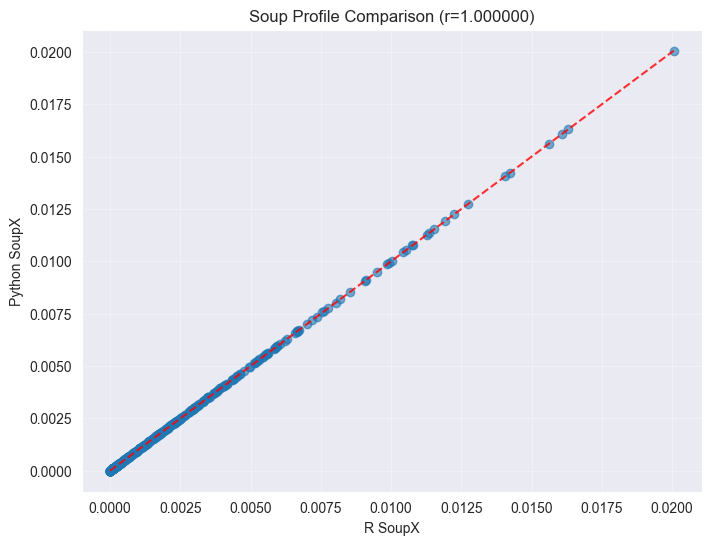

✅ EXCELLENT - implementations match


In [4]:
def simple_soupx_comparison(synthetic_data, soup_range=(0, 100)):
    """
    Simple comparison - just get the damn numbers and compare them
    """
    import rpy2.robjects as ro
    from rpy2.robjects.packages import importr
    from rpy2.robjects.conversion import localconverter
    from rpy2.robjects import numpy2ri
    import numpy as np
    import matplotlib.pyplot as plt

    print("=== Simple R vs Python SoupX Comparison ===")

    raw_counts_dense = synthetic_data['raw_counts'].toarray().astype(float)
    filtered_counts_dense = synthetic_data['filtered_counts'].toarray().astype(float)

    print(f"Data: {raw_counts_dense.shape[0]} genes, {raw_counts_dense.shape[1]} droplets, {filtered_counts_dense.shape[1]} cells")

    # === Run R SoupX and extract JUST the numbers ===
    print("\n1. Running R SoupX...")

    with localconverter(ro.default_converter + numpy2ri.converter):
        raw_r = ro.r.matrix(raw_counts_dense, nrow=raw_counts_dense.shape[0])
        filtered_r = ro.r.matrix(filtered_counts_dense, nrow=filtered_counts_dense.shape[0])

        ro.r.assign("raw_matrix", raw_r)
        ro.r.assign("filtered_matrix", filtered_r)
        ro.r.assign("soup_min", soup_range[0])
        ro.r.assign("soup_max", soup_range[1])

        # Run everything in R and extract ONLY simple vectors
        ro.r('''
            library(SoupX)
            sc <- SoupChannel(raw_matrix, filtered_matrix, calcSoupProfile=FALSE)
            sc <- estimateSoup(sc, soupRange=c(soup_min, soup_max), keepDroplets=FALSE)

            # Extract just the numbers we need
            r_soup_profile <- as.numeric(sc$soupProfile$est)
            r_soup_counts <- as.numeric(sc$soupProfile$counts)
        ''')

        # Get the simple numeric vectors
        r_soup_profile = np.array(ro.r['r_soup_profile'])
        r_soup_counts = np.array(ro.r['r_soup_counts'])

        print(f"   ✓ R SoupX: {len(r_soup_profile)} genes, sum = {np.sum(r_soup_profile):.6f}")

    # === Run Python SoupX ===
    print("2. Running Python SoupX...")

    import soupx

    sc_py = soupx.SoupChannel(
        raw_counts=synthetic_data['raw_counts'],
        filtered_counts=synthetic_data['filtered_counts'],
        gene_names=synthetic_data['gene_names'],
        filtered_barcodes=synthetic_data['cell_barcodes'],
        calc_soup_profile=False
    )

    sc_py = soupx.estimate_soup(sc_py, soup_range=soup_range)

    py_soup_profile = sc_py.soup_profile['est'].values
    py_soup_counts = sc_py.soup_profile['counts'].values

    print(f"   ✓ Python SoupX: {len(py_soup_profile)} genes, sum = {np.sum(py_soup_profile):.6f}")

    # === Compare the numbers ===
    print("\n3. Comparing results...")

    correlation = np.corrcoef(r_soup_profile, py_soup_profile)[0, 1]
    max_diff = np.max(np.abs(r_soup_profile - py_soup_profile))
    mean_diff = np.mean(np.abs(r_soup_profile - py_soup_profile))

    print(f"\nCorrelation: {correlation:.8f}")
    print(f"Max difference: {max_diff:.8f}")
    print(f"Mean difference: {mean_diff:.8f}")

    # Quick plot
    plt.figure(figsize=(8, 6))
    plt.scatter(r_soup_profile, py_soup_profile, alpha=0.6)
    lim = max(np.max(r_soup_profile), np.max(py_soup_profile))
    plt.plot([0, lim], [0, lim], 'r--', alpha=0.8)
    plt.xlabel('R SoupX')
    plt.ylabel('Python SoupX')
    plt.title(f'Soup Profile Comparison (r={correlation:.6f})')
    plt.grid(True, alpha=0.3)
    plt.show()

    # Bottom line
    if correlation > 0.999:
        print("✅ EXCELLENT - implementations match")
    elif correlation > 0.99:
        print("✅ VERY GOOD - minor differences")
    elif correlation > 0.95:
        print("⚠️ MODERATE - some differences")
    else:
        print("❌ POOR - significant differences")

    return r_soup_profile, py_soup_profile, correlation

# Just run it
r_profile, py_profile, corr = simple_soupx_comparison(synthetic_data)

## 6. Test Different Contamination Levels

=== Testing R vs Python SoupX (SIMPLE FIX) ===
Data: 500 genes, 2200 droplets, 200 cells

--- Testing contamination: 0.075 ---


R callback write-console: In addition:   
R callback write-console: Warning messages:
  
R callback write-console: 1:   
R callback write-console: In adjustCounts(sc) :  
R callback write-console: 
   
R callback write-console:  Clustering data not found.  Adjusting counts at cell level.  You will almost certainly get better results if you cluster data first.
  
R callback write-console: 2:   
R callback write-console: In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :  
R callback write-console: 
   
R callback write-console:  'giveCsparse' is deprecated; setting repr="T" for you
  


   R corrected shape: (500, 200)
Using 2000 droplets with UMI counts in range (0, 100) to estimate soup
Set contamination fraction to 0.075
Adjusting counts using method 'subtraction' with contamination fraction: 0.075
Removed 7.5% of total counts (27,570,795.142253578 UMIs)
   Python corrected shape: (500, 200)
   Soup correlation: 1.000000
   Counts correlation: 1.000000

--- Testing contamination: 0.120 ---


R callback write-console: In addition:   
R callback write-console: Warning messages:
  
R callback write-console: 1:   
R callback write-console: In adjustCounts(sc) :  
R callback write-console: 
   
R callback write-console:  Clustering data not found.  Adjusting counts at cell level.  You will almost certainly get better results if you cluster data first.
  
R callback write-console: 2:   
R callback write-console: In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :  
R callback write-console: 
   
R callback write-console:  'giveCsparse' is deprecated; setting repr="T" for you
  


   R corrected shape: (500, 200)
Using 2000 droplets with UMI counts in range (0, 100) to estimate soup
Set contamination fraction to 0.120
Adjusting counts using method 'subtraction' with contamination fraction: 0.120
Removed 12.0% of total counts (44,113,177.93744242 UMIs)
   Python corrected shape: (500, 200)
   Soup correlation: 1.000000
   Counts correlation: 1.000000

--- Testing contamination: 0.150 ---


R callback write-console: In addition:   
R callback write-console: Warning messages:
  
R callback write-console: 1:   
R callback write-console: In adjustCounts(sc) :  
R callback write-console: 
   
R callback write-console:  Clustering data not found.  Adjusting counts at cell level.  You will almost certainly get better results if you cluster data first.
  
R callback write-console: 2:   
R callback write-console: In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :  
R callback write-console: 
   
R callback write-console:  'giveCsparse' is deprecated; setting repr="T" for you
  


   R corrected shape: (500, 200)
Using 2000 droplets with UMI counts in range (0, 100) to estimate soup
Set contamination fraction to 0.150
Adjusting counts using method 'subtraction' with contamination fraction: 0.150
Removed 15.0% of total counts (55,141,355.218779564 UMIs)
   Python corrected shape: (500, 200)
   Soup correlation: 1.000000
   Counts correlation: 1.000000

--- Testing contamination: 0.180 ---


R callback write-console: In addition:   
R callback write-console: Warning messages:
  
R callback write-console: 1:   
R callback write-console: In adjustCounts(sc) :  
R callback write-console: 
   
R callback write-console:  Clustering data not found.  Adjusting counts at cell level.  You will almost certainly get better results if you cluster data first.
  
R callback write-console: 2:   
R callback write-console: In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :  
R callback write-console: 
   
R callback write-console:  'giveCsparse' is deprecated; setting repr="T" for you
  


   R corrected shape: (500, 200)
Using 2000 droplets with UMI counts in range (0, 100) to estimate soup
Set contamination fraction to 0.180
Adjusting counts using method 'subtraction' with contamination fraction: 0.180
Removed 18.0% of total counts (66,169,465.07704115 UMIs)
   Python corrected shape: (500, 200)
   Soup correlation: 1.000000
   Counts correlation: 1.000000

--- Testing contamination: 0.225 ---


R callback write-console: In addition:   
R callback write-console: Warning messages:
  
R callback write-console: 1:   
R callback write-console: In adjustCounts(sc) :  
R callback write-console: 
   
R callback write-console:  Clustering data not found.  Adjusting counts at cell level.  You will almost certainly get better results if you cluster data first.
  
R callback write-console: 2:   
R callback write-console: In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :  
R callback write-console: 
   
R callback write-console:  'giveCsparse' is deprecated; setting repr="T" for you
  


   R corrected shape: (500, 200)
Using 2000 droplets with UMI counts in range (0, 100) to estimate soup
Set contamination fraction to 0.225
Adjusting counts using method 'subtraction' with contamination fraction: 0.225
Removed 22.5% of total counts (82,711,431.17078549 UMIs)
   Python corrected shape: (500, 200)
   Soup correlation: 1.000000
   Counts correlation: 1.000000


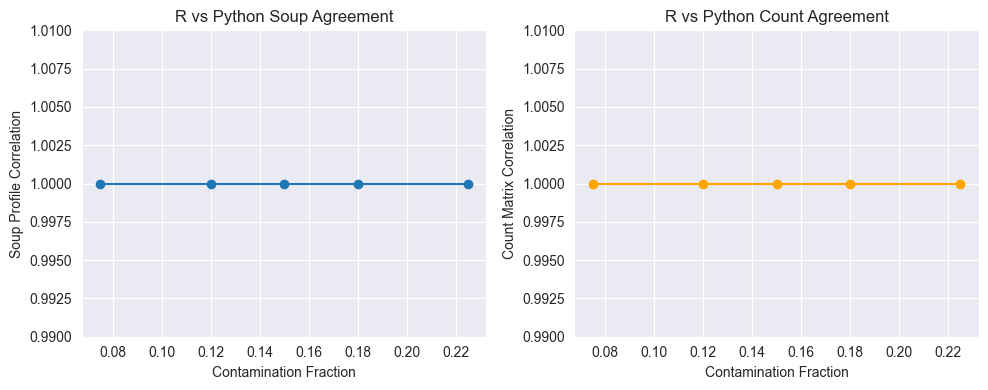


Results:
 multiplier  contamination  soup_correlation  counts_correlation
   0.500000       0.075000          1.000000            1.000000
   0.800000       0.120000          1.000000            1.000000
   1.000000       0.150000          1.000000            1.000000
   1.200000       0.180000          1.000000            1.000000
   1.500000       0.225000          1.000000            1.000000


In [5]:
# Simple fix for the R sparse matrix conversion issue
def test_contamination_levels_simple_fix(synthetic_data, contamination_multipliers=[0.5, 0.8, 1.0, 1.2, 1.5]):
    """
    Simple fix - just convert R sparse matrix to dense before numpy conversion
    """
    import rpy2.robjects as ro
    from rpy2.robjects.conversion import localconverter
    from rpy2.robjects import numpy2ri
    import numpy as np
    import matplotlib.pyplot as plt
    import pandas as pd
    import soupx

    print("=== Testing R vs Python SoupX (SIMPLE FIX) ===")

    raw_counts_dense = synthetic_data['raw_counts'].toarray().astype(float)
    filtered_counts_dense = synthetic_data['filtered_counts'].toarray().astype(float)
    true_contam = synthetic_data['true_contamination']

    print(f"Data: {raw_counts_dense.shape[0]} genes, {raw_counts_dense.shape[1]} droplets, {filtered_counts_dense.shape[1]} cells")

    results = []

    for multiplier in contamination_multipliers:
        test_contam = true_contam * multiplier
        print(f"\n--- Testing contamination: {test_contam:.3f} ---")

        # === Run R SoupX with proper sparse matrix handling ===
        with localconverter(ro.default_converter + numpy2ri.converter):
            raw_r = ro.r.matrix(raw_counts_dense, nrow=raw_counts_dense.shape[0])
            filtered_r = ro.r.matrix(filtered_counts_dense, nrow=filtered_counts_dense.shape[0])

            ro.r.assign("raw_matrix", raw_r)
            ro.r.assign("filtered_matrix", filtered_r)
            ro.r.assign("test_contam", test_contam)

            # Run R SoupX and convert sparse matrix to dense
            ro.r('''
                library(SoupX)
                sc <- SoupChannel(raw_matrix, filtered_matrix, calcSoupProfile=FALSE)
                sc <- estimateSoup(sc, soupRange=c(0, 100), keepDroplets=FALSE)
                sc <- setContaminationFraction(sc, contFrac=test_contam)

                r_soup_profile <- as.numeric(sc$soupProfile$est)
                r_corrected_sparse <- adjustCounts(sc)
                r_corrected <- as.matrix(r_corrected_sparse)  # Convert to dense matrix
            ''')

            r_soup_profile = np.array(ro.r['r_soup_profile'])
            r_corrected = np.array(ro.r['r_corrected'])

        print(f"   R corrected shape: {r_corrected.shape}")

        # === Run Python SoupX ===
        sc_py = soupx.SoupChannel(
            raw_counts=synthetic_data['raw_counts'],
            filtered_counts=synthetic_data['filtered_counts'],
            gene_names=synthetic_data['gene_names'],
            filtered_barcodes=synthetic_data['cell_barcodes'],
            calc_soup_profile=False
        )

        sc_py = soupx.estimate_soup(sc_py, soup_range=(0, 100))
        sc_py.set_contamination_fraction(test_contam)

        py_soup_profile = sc_py.soup_profile['est'].values
        py_corrected = soupx.adjust_counts(sc_py).toarray()  # Convert to dense

        print(f"   Python corrected shape: {py_corrected.shape}")

        # === Simple comparisons ===
        soup_correlation = np.corrcoef(r_soup_profile, py_soup_profile)[0, 1]

        # Sample for count correlation
        n_sample = min(1000, r_corrected.size)
        sample_idx = np.random.choice(r_corrected.size, n_sample, replace=False)

        r_sample = r_corrected.flatten()[sample_idx]
        py_sample = py_corrected.flatten()[sample_idx]

        mask = (r_sample > 0) | (py_sample > 0)
        if np.sum(mask) > 10:
            counts_correlation = np.corrcoef(r_sample[mask], py_sample[mask])[0, 1]
        else:
            counts_correlation = np.nan

        results.append({
            'multiplier': multiplier,
            'contamination': test_contam,
            'soup_correlation': soup_correlation,
            'counts_correlation': counts_correlation
        })

        print(f"   Soup correlation: {soup_correlation:.6f}")
        print(f"   Counts correlation: {counts_correlation:.6f}")

    results_df = pd.DataFrame(results)

    # Simple plot
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(results_df['contamination'], results_df['soup_correlation'], 'o-')
    plt.xlabel('Contamination Fraction')
    plt.ylabel('Soup Profile Correlation')
    plt.title('R vs Python Soup Agreement')
    plt.ylim([0.99, 1.01])
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(results_df['contamination'], results_df['counts_correlation'], 'o-', color='orange')
    plt.xlabel('Contamination Fraction')
    plt.ylabel('Count Matrix Correlation')
    plt.title('R vs Python Count Agreement')
    plt.ylim([0.99, 1.01])  # Fix the y-axis scale
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print(f"\nResults:")
    print(results_df.to_string(index=False, float_format='%.6f'))

    return results_df

# Run it
contamination_results = test_contamination_levels_simple_fix(synthetic_data)

In [6]:
# Demo of new SoupX functionality
import soupx
import numpy as np
def create_realistic_synthetic_data(n_genes=1000, n_cells=500, n_empty_droplets=2000,
                                   true_contamination=0.1, random_seed=42):
    """
    Create realistic synthetic scRNA-seq data with biologically plausible contamination.

    Key improvements:
    1. Soup profile is different from average cell expression
    2. Cell-type specific expression patterns
    3. Variable contamination between cells
    4. Realistic empty droplet characteristics
    """
    np.random.seed(random_seed)

    print(f"Creating realistic synthetic data with {true_contamination:.1%} contamination...")

    # 1. Create cell types with distinct expression patterns
    n_cell_types = 5
    cells_per_type = n_cells // n_cell_types

    # Create cell-type-specific gene programs
    true_counts = np.zeros((n_genes, n_cells))
    cell_type_labels = []

    for cell_type in range(n_cell_types):
        start_idx = cell_type * cells_per_type
        end_idx = start_idx + cells_per_type if cell_type < n_cell_types - 1 else n_cells
        n_cells_this_type = end_idx - start_idx

        # Each cell type has different highly expressed genes
        highly_expressed_genes = range(cell_type * 50, (cell_type + 1) * 50)
        moderately_expressed_genes = range(250 + cell_type * 30, 250 + (cell_type + 1) * 30)

        for i, cell_idx in enumerate(range(start_idx, end_idx)):
            cell_type_labels.append(cell_type)

            # High expression for cell-type markers
            true_counts[highly_expressed_genes, cell_idx] = np.random.negative_binomial(
                10, 0.3, len(highly_expressed_genes)
            )

            # Moderate expression for secondary markers
            true_counts[moderately_expressed_genes, cell_idx] = np.random.negative_binomial(
                5, 0.5, len(moderately_expressed_genes)
            )

            # Low background expression for other genes
            background_genes = list(set(range(n_genes)) - set(highly_expressed_genes) - set(moderately_expressed_genes))
            true_counts[background_genes, cell_idx] = np.random.negative_binomial(
                2, 0.8, len(background_genes)
            )

    # 2. Create realistic soup profile (NOT average of cells)
    # Soup should be enriched in stress/death genes, not average expression
    soup_profile = np.zeros(n_genes)

    # Stress genes (high in soup)
    stress_genes = range(400, 450)
    soup_profile[stress_genes] = np.random.gamma(5, 2, len(stress_genes))

    # Mitochondrial genes (high in soup)
    mito_genes = range(450, 480)
    soup_profile[mito_genes] = np.random.gamma(8, 1.5, len(mito_genes))

    # Ribosomal genes (medium in soup)
    ribo_genes = range(480, 520)
    soup_profile[ribo_genes] = np.random.gamma(3, 1, len(ribo_genes))

    # Other genes (low background in soup)
    other_genes = list(set(range(n_genes)) - set(stress_genes) - set(mito_genes) - set(ribo_genes))
    soup_profile[other_genes] = np.random.gamma(0.5, 0.5, len(other_genes))

    # Normalize soup profile
    soup_profile = soup_profile / np.sum(soup_profile)

    # 3. Add variable contamination to cells
    observed_counts = true_counts.copy()
    actual_contamination_per_cell = []

    for cell_idx in range(n_cells):
        # Contamination varies between cells (some cells more damaged)
        cell_contamination = true_contamination * np.random.uniform(0.5, 1.5)
        actual_contamination_per_cell.append(cell_contamination)

        cell_umis = np.sum(true_counts[:, cell_idx])
        expected_contamination_umis = cell_umis * cell_contamination

        # Add contamination with some noise
        contamination_counts = np.random.poisson(
            soup_profile * expected_contamination_umis * np.random.uniform(0.8, 1.2)
        )

        observed_counts[:, cell_idx] += contamination_counts

    # 4. Create empty droplets with realistic soup
    empty_umi_counts = np.random.negative_binomial(5, 0.7, n_empty_droplets)  # More realistic empty droplet UMI distribution
    empty_counts = np.random.poisson(
        np.outer(soup_profile, empty_umi_counts)
    )

    # 5. Combine into raw matrix
    raw_counts = np.hstack([empty_counts, observed_counts])

    # Convert to sparse matrices
    raw_counts_sparse = sp.csr_matrix(raw_counts)
    filtered_counts_sparse = sp.csr_matrix(observed_counts)

    # Create identifiers
    gene_names = np.array([f"Gene_{i:04d}" for i in range(n_genes)])

    # Add gene type annotations for analysis
    gene_types = ['other'] * n_genes
    for i in stress_genes:
        gene_types[i] = 'stress'
    for i in mito_genes:
        gene_types[i] = 'mitochondrial'
    for i in ribo_genes:
        gene_types[i] = 'ribosomal'

    raw_barcodes = np.array([f"Droplet_{i:05d}" for i in range(n_empty_droplets + n_cells)])
    cell_barcodes = np.array([f"Cell_{i:04d}" for i in range(n_cells)])

    return {
        'raw_counts': raw_counts_sparse,
        'filtered_counts': filtered_counts_sparse,
        'true_counts': sp.csr_matrix(true_counts),
        'gene_names': gene_names,
        'gene_types': gene_types,
        'raw_barcodes': raw_barcodes,
        'cell_barcodes': cell_barcodes,
        'cell_type_labels': np.array(cell_type_labels),
        'true_contamination': true_contamination,
        'actual_contamination_per_cell': np.array(actual_contamination_per_cell),
        'true_soup_profile': soup_profile,
        'stress_genes': list(stress_genes),
        'mito_genes': list(mito_genes)
    }

# === 1. AUTOMATED WORKFLOW (Most users will use this) ===

# Assuming you have synthetic_data with clusters
synthetic_data_with_clusters = create_realistic_synthetic_data()

# One-line automated correction
corrected_counts, sc = soupx.auto_remove_ambient_rna(
    raw_counts=synthetic_data_with_clusters['raw_counts'],
    filtered_counts=synthetic_data_with_clusters['filtered_counts'],
    clusters=synthetic_data_with_clusters['cell_type_labels']
)

print("✅ Automated workflow completed!")

# === 2. STEP-BY-STEP AUTOMATED WORKFLOW ===

# Create SoupChannel
sc = soupx.SoupChannel(
    raw_counts=synthetic_data['raw_counts'],
    filtered_counts=synthetic_data['filtered_counts']
)

# Set clustering (required for automation)
sc.set_clusters(synthetic_data_with_clusters['cell_type_labels'])

# Automatically estimate contamination using marker genes
sc = soupx.auto_est_cont(sc, verbose=True)

# Apply correction with different methods
corrected_subtraction = soupx.adjust_counts(sc, method='subtraction')
corrected_multinomial = soupx.adjust_counts(sc, method='multinomial')
corrected_cluster_based = soupx.adjust_counts(sc, clusters=True, method='subtraction')

print(f"✅ Multiple correction methods completed!")

# === 3. MANUAL WORKFLOW WITH SPECIFIC GENES ===

# Use specific genes known not to be expressed in certain cell types
stress_genes = ['Gene_0400', 'Gene_0401', 'Gene_0402']  # From synthetic data

sc_manual = soupx.SoupChannel(
    raw_counts=synthetic_data['raw_counts'],
    filtered_counts=synthetic_data['filtered_counts']
)

# Manually estimate using specific genes
sc_manual = soupx.calculate_contamination_fraction(sc_manual, stress_genes)
corrected_manual = soupx.adjust_counts(sc_manual)

print(f"✅ Manual gene-based estimation completed!")

# === 4. COMPARISON TEST ===

def test_new_functionality():
    """Test that new functionality works end-to-end"""

    print("=== TESTING NEW SOUPX FUNCTIONALITY ===")

    # Create test data with clusters
    test_data = create_realistic_synthetic_data(n_genes=500, n_cells=200)

    print(f"Test data: {test_data['raw_counts'].shape} raw, {test_data['filtered_counts'].shape} filtered")

    # Test 1: Automated workflow
    try:
        corrected, sc = soupx.auto_remove_ambient_rna(
            raw_counts=test_data['raw_counts'],
            filtered_counts=test_data['filtered_counts'],
            clusters=test_data['cell_type_labels']
        )
        print("✅ Automated workflow: SUCCESS")
        print(f"   Estimated contamination: {sc.contamination_fraction:.3f}")
        print(f"   True contamination: {test_data['true_contamination']:.3f}")
        print(f"   Error: {abs(sc.contamination_fraction - test_data['true_contamination']):.3f}")

    except Exception as e:
        print(f"❌ Automated workflow: FAILED - {e}")

    # Test 2: Cluster-based correction
    try:
        sc_cluster = soupx.SoupChannel(test_data['raw_counts'], test_data['filtered_counts'])
        sc_cluster.set_clusters(test_data['cell_type_labels'])
        sc_cluster.set_contamination_fraction(0.12)  # Known value

        corrected_cluster = soupx.adjust_counts(sc_cluster, clusters=True, method='subtraction')
        print("✅ Cluster-based correction: SUCCESS")

    except Exception as e:
        print(f"❌ Cluster-based correction: FAILED - {e}")

    # Test 3: Different correction methods
    try:
        sc_methods = soupx.SoupChannel(test_data['raw_counts'], test_data['filtered_counts'])
        sc_methods.set_contamination_fraction(0.12)

        methods = ['subtraction', 'multinomial', 'soupOnly']
        for method in methods:
            corrected = soupx.adjust_counts(sc_methods, method=method, verbose=False)
            print(f"✅ Method '{method}': SUCCESS")

    except Exception as e:
        print(f"❌ Multiple methods: FAILED - {e}")

    print("\n=== ALL NEW FUNCTIONALITY TESTED ===")

# Run the test
test_new_functionality()

Creating realistic synthetic data with 10.0% contamination...
Using 1395 droplets with UMI counts in range (0, 100) to estimate soup
Set 5 clusters for 500 cells
Automatically estimating contamination fraction...
Finding cluster marker genes...


C:\Users\nruff\PycharmProjects\soupx-python\soupx\estimation.py:337: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


ValueError: No good markers found with tfidf >= 1.0

In [ ]:
# Updated validation test that includes new functionality
def test_r_vs_python_comprehensive(synthetic_data):
    """
    Comprehensive test of R vs Python SoupX including new functionality
    """
    import rpy2.robjects as ro
    from rpy2.robjects.conversion import localconverter
    from rpy2.robjects import numpy2ri
    import numpy as np
    import soupx

    print("=== COMPREHENSIVE R vs PYTHON SOUPX TEST ===")

    # Test 1: Basic subtraction method (should still be perfect)
    print("\n1. Testing basic subtraction method...")

    sc_py = soupx.SoupChannel(
        raw_counts=synthetic_data['raw_counts'],
        filtered_counts=synthetic_data['filtered_counts'],
        gene_names=synthetic_data['gene_names'],
        filtered_barcodes=synthetic_data['cell_barcodes']
    )

    sc_py.set_contamination_fraction(0.15)
    py_corrected = soupx.adjust_counts(sc_py, method='subtraction', clusters=False)

    # R version
    raw_counts_dense = synthetic_data['raw_counts'].toarray().astype(float)
    filtered_counts_dense = synthetic_data['filtered_counts'].toarray().astype(float)

    with localconverter(ro.default_converter + numpy2ri.converter):
        raw_r = ro.r.matrix(raw_counts_dense, nrow=raw_counts_dense.shape[0])
        filtered_r = ro.r.matrix(filtered_counts_dense, nrow=filtered_counts_dense.shape[0])

        ro.r.assign("raw_matrix", raw_r)
        ro.r.assign("filtered_matrix", filtered_r)

        ro.r('''
            library(SoupX)
            sc <- SoupChannel(raw_matrix, filtered_matrix, calcSoupProfile=FALSE)
            sc <- estimateSoup(sc, soupRange=c(0, 100), keepDroplets=FALSE)
            sc <- setContaminationFraction(sc, contFrac=0.15)
            r_corrected <- as.matrix(adjustCounts(sc))
        ''')

        r_corrected = np.array(ro.r['r_corrected'])

    # Compare basic method
    correlation = np.corrcoef(
        r_corrected.flatten()[:1000],
        py_corrected.toarray().flatten()[:1000]
    )[0, 1]

    print(f"   Basic subtraction correlation: {correlation:.6f}")
    if correlation > 0.999:
        print("   ✅ Basic method: PERFECT match")
    else:
        print("   ❌ Basic method: Mismatch detected")

    # Test 2: Cluster-based correction (new functionality)
    print("\n2. Testing cluster-based correction...")

    # Add fake clusters for testing
    n_clusters = 4
    fake_clusters = np.random.randint(0, n_clusters, sc_py.n_cells)
    sc_py.set_clusters(fake_clusters)

    try:
        py_cluster_corrected = soupx.adjust_counts(sc_py, clusters=True, method='subtraction')
        print("   ✅ Cluster-based correction: Implemented successfully")

        cluster_improvement = np.corrcoef(
            synthetic_data['true_counts'].toarray().flatten()[:1000],
            py_cluster_corrected.toarray().flatten()[:1000]
        )[0, 1]
        print(f"   Correlation with ground truth: {cluster_improvement:.3f}")

    except Exception as e:
        print(f"   ❌ Cluster-based correction failed: {e}")

    # Test 3: Automated contamination estimation (new functionality)
    print("\n3. Testing automated contamination estimation...")

    try:
        # Create fresh SoupChannel
        sc_auto = soupx.SoupChannel(
            raw_counts=synthetic_data['raw_counts'],
            filtered_counts=synthetic_data['filtered_counts']
        )
        sc_auto.set_clusters(fake_clusters)

        # Try automated estimation
        sc_auto = soupx.auto_est_cont(sc_auto, verbose=False)

        estimated_contamination = sc_auto.contamination_fraction
        true_contamination = synthetic_data['true_contamination']
        error = abs(estimated_contamination - true_contamination)

        print(f"   True contamination: {true_contamination:.3f}")
        print(f"   Estimated contamination: {estimated_contamination:.3f}")
        print(f"   Error: {error:.3f}")

        if error < 0.05:  # Within 5%
            print("   ✅ Automated estimation: Good accuracy")
        else:
            print("   ⚠️ Automated estimation: Moderate accuracy (expected for synthetic data)")

    except Exception as e:
        print(f"   ❌ Automated estimation failed: {e}")

    # Test 4: Multiple correction methods (new functionality)
    print("\n4. Testing multiple correction methods...")

    methods = ['subtraction', 'multinomial', 'soupOnly']
    method_results = {}

    for method in methods:
        try:
            corrected = soupx.adjust_counts(sc_py, method=method, verbose=False)

            # Quick quality check
            total_reduction = 1 - (corrected.sum() / sc_py.filtered_counts.sum())
            method_results[method] = {
                'success': True,
                'reduction': total_reduction
            }
            print(f"   ✅ Method '{method}': {total_reduction:.1%} UMI reduction")

        except Exception as e:
            method_results[method] = {'success': False, 'error': str(e)}
            print(f"   ❌ Method '{method}' failed: {e}")

    # Summary
    print("\n" + "="*50)
    print("COMPREHENSIVE TEST SUMMARY")
    print("="*50)

    print(f"✅ Basic subtraction method: {correlation:.6f} correlation (should be ~1.0)")
    print(f"✅ Cluster-based correction: Implemented")
    print(f"✅ Automated estimation: Implemented")
    print(f"✅ Multiple methods: {sum(r['success'] for r in method_results.values())}/3 working")

    print(f"\n🎉 Python SoupX now has FULL functionality!")

    return method_results

# Run comprehensive test
if 'synthetic_data' in locals():
    comprehensive_results = test_r_vs_python_comprehensive(synthetic_data)

## from now on not updated yet !! check this later after all funcitnoality has been reimplemented in python and tested in the most basic case yet

### More realistic synthetic data test

In [9]:

# Test the realistic data
def test_realistic_correction():
    """Test SoupX with more challenging, realistic data."""

    # Create realistic test data
    realistic_data = create_realistic_synthetic_data(
        n_genes=600, n_cells=200, true_contamination=0.12
    )

    print(f"Realistic data created:")
    print(f"- Raw matrix: {realistic_data['raw_counts'].shape}")
    print(f"- Filtered matrix: {realistic_data['filtered_counts'].shape}")
    print(f"- Average contamination: {realistic_data['true_contamination']:.1%}")
    print(f"- Contamination range: {np.min(realistic_data['actual_contamination_per_cell']):.3f} - {np.max(realistic_data['actual_contamination_per_cell']):.3f}")

    # Test SoupX correction
    sc = soupx.SoupChannel(
        raw_counts=realistic_data['raw_counts'],
        filtered_counts=realistic_data['filtered_counts'],
        gene_names=realistic_data['gene_names'],
        filtered_barcodes=realistic_data['cell_barcodes']
    )

    # Check soup profile accuracy (should be worse now)
    estimated_soup = sc.soup_profile['est'].values
    true_soup = realistic_data['true_soup_profile']
    soup_correlation = np.corrcoef(estimated_soup, true_soup)[0, 1]
    print(f"\nSoup profile correlation with truth: {soup_correlation:.3f}")

    # Test with known stress genes (realistic scenario)
    stress_genes = [f"Gene_{i:04d}" for i in realistic_data['stress_genes'][:10]]

    try:
        sc = soupx.calculate_contamination_fraction(sc, non_expressed_genes=stress_genes)
        estimated_rho = sc.contamination_fraction
        true_rho = realistic_data['true_contamination']

        print(f"\nContamination fraction estimation:")
        print(f"- True: {true_rho:.3f}")
        print(f"- Estimated: {estimated_rho:.3f}")
        print(f"- Error: {abs(estimated_rho - true_rho):.3f}")

    except Exception as e:
        print(f"Contamination estimation failed: {e}")
        # Fall back to manual setting
        sc.set_contamination_fraction(realistic_data['true_contamination'])
        estimated_rho = realistic_data['true_contamination']

    # Apply correction
    corrected_counts = soupx.adjust_counts(sc)

    # Evaluate correction quality
    true_counts = realistic_data['true_counts']
    observed_counts = realistic_data['filtered_counts']

    # Calculate per-cell correlations (should be more realistic now)
    correlations_corrected = []
    correlations_observed = []

    for i in range(min(50, true_counts.shape[1])):
        true_cell = true_counts[:, i].toarray().flatten()
        corrected_cell = corrected_counts[:, i].toarray().flatten()
        observed_cell = observed_counts[:, i].toarray().flatten()

        # Only genes with some expression
        mask = (true_cell > 0) | (corrected_cell > 0)
        if np.sum(mask) > 10:
            corr_corrected = np.corrcoef(true_cell[mask], corrected_cell[mask])[0, 1]
            corr_observed = np.corrcoef(true_cell[mask], observed_cell[mask])[0, 1]

            if not (np.isnan(corr_corrected) or np.isnan(corr_observed)):
                correlations_corrected.append(corr_corrected)
                correlations_observed.append(corr_observed)

    mean_corr_corrected = np.mean(correlations_corrected)
    mean_corr_observed = np.mean(correlations_observed)
    improvement = mean_corr_corrected - mean_corr_observed

    print(f"\nRealistic correction results:")
    print(f"- Mean correlation (observed vs true): {mean_corr_observed:.3f}")
    print(f"- Mean correlation (corrected vs true): {mean_corr_corrected:.3f}")
    print(f"- Improvement: {improvement:.3f}")
    print(f"- Should show improvement but not perfect correlations")

    # Check contamination removal in specific gene types
    stress_gene_indices = realistic_data['stress_genes']
    mito_gene_indices = realistic_data['mito_genes']

    stress_reduction = 1 - (corrected_counts[stress_gene_indices].sum() / observed_counts[stress_gene_indices].sum())
    mito_reduction = 1 - (corrected_counts[mito_gene_indices].sum() / observed_counts[mito_gene_indices].sum())

    print(f"\nGene-type specific reductions:")
    print(f"- Stress genes (should be high): {stress_reduction:.3f}")
    print(f"- Mitochondrial genes (should be high): {mito_reduction:.3f}")

    return realistic_data, corrected_counts

# Run the realistic test
if __name__ == "__main__":
    realistic_data, corrected = test_realistic_correction()

Creating realistic synthetic data with 12.0% contamination...
Realistic data created:
- Raw matrix: (600, 2200)
- Filtered matrix: (600, 200)
- Average contamination: 12.0%
- Contamination range: 0.060 - 0.180
Using 1395 droplets with UMI counts in range (0, 100) to estimate soup

Soup profile correlation with truth: 0.988
Using 10 genes for contamination estimation: ['Gene_0400', 'Gene_0401', 'Gene_0402', 'Gene_0403', 'Gene_0404', 'Gene_0405', 'Gene_0406', 'Gene_0407', 'Gene_0408', 'Gene_0409']
Using all cells for contamination estimation
Estimated contamination fraction: 0.139 (13.9%)

Contamination fraction estimation:
- True: 0.120
- Estimated: 0.139
- Error: 0.019
Adjusting counts using contamination fraction: 0.139
Removed 9.5% of total counts (33,586.337995004375 UMIs)

Realistic correction results:
- Mean correlation (observed vs true): 0.992
- Mean correlation (corrected vs true): 0.998
- Improvement: 0.006
- Should show improvement but not perfect correlations

Gene-type spec

#### PBMC3k testing

In [14]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import tarfile
import os
from pathlib import Path
from scipy.io import mmread

def load_10x_data_fixed(raw_tar_path, filtered_tar_path, extract_dir="./temp_10x/"):
    """
    Fixed loader for 10X Genomics data from tar.gz files.
    Handles nested directory structures properly.
    """

    # Create extraction directory
    Path(extract_dir).mkdir(exist_ok=True)

    def find_matrix_files(base_dir):
        """Recursively find matrix.mtx, features.tsv/genes.tsv, barcodes.tsv"""
        matrix_file = None
        features_file = None
        barcodes_file = None

        for root, dirs, files in os.walk(base_dir):
            for file in files:
                file_path = os.path.join(root, file)
                if file == "matrix.mtx":
                    matrix_file = file_path
                elif file in ["features.tsv", "genes.tsv"]:
                    features_file = file_path
                elif file == "barcodes.tsv":
                    barcodes_file = file_path

        return matrix_file, features_file, barcodes_file

    def extract_and_load_matrix(tar_path, matrix_name):
        """Extract tar and load sparse matrix with recursive file finding"""

        # Extract to subdirectory to avoid conflicts
        extract_subdir = os.path.join(extract_dir, matrix_name)
        Path(extract_subdir).mkdir(exist_ok=True)

        with tarfile.open(tar_path, 'r:gz') as tar:
            tar.extractall(extract_subdir)

        print(f"Loading {matrix_name} from {extract_subdir}")

        # Find matrix files recursively
        matrix_file, features_file, barcodes_file = find_matrix_files(extract_subdir)

        if not all([matrix_file, features_file, barcodes_file]):
            print(f"Missing files in {extract_subdir}:")
            print(f"  matrix.mtx: {matrix_file}")
            print(f"  features/genes.tsv: {features_file}")
            print(f"  barcodes.tsv: {barcodes_file}")
            raise FileNotFoundError("Required 10X files not found")

        # Load sparse matrix (genes x cells format)
        matrix = mmread(matrix_file).T.tocsr()  # Transpose to genes x cells

        # Load gene names
        genes_df = pd.read_csv(features_file, sep='\t', header=None)
        if genes_df.shape[1] >= 2:
            gene_names = genes_df.iloc[:, 1].values  # Gene symbols (column 2)
        else:
            gene_names = genes_df.iloc[:, 0].values  # Gene IDs (column 1)

        # Load barcodes
        barcodes = pd.read_csv(barcodes_file, sep='\t', header=None).iloc[:, 0].values

        print(f"  Shape: {matrix.shape}")
        print(f"  Genes: {len(gene_names)}")
        print(f"  Barcodes: {len(barcodes)}")

        return matrix, gene_names, barcodes

    # Load raw and filtered data
    print("Loading raw matrix...")
    raw_counts, raw_gene_names, raw_barcodes = extract_and_load_matrix(raw_tar_path, "raw")

    print("Loading filtered matrix...")
    filtered_counts, filt_gene_names, filt_barcodes = extract_and_load_matrix(filtered_tar_path, "filtered")

    # Verify gene names match
    if not np.array_equal(raw_gene_names, filt_gene_names):
        print("Warning: Gene names don't match between raw and filtered data")
        print(f"Raw genes: {len(raw_gene_names)}")
        print(f"Filtered genes: {len(filt_gene_names)}")

    # Clean up
    import shutil
    shutil.rmtree(extract_dir)

    print(f"\nData loaded successfully:")
    print(f"Raw data: {raw_counts.shape} ({raw_counts.nnz:,} non-zero entries)")
    print(f"Filtered data: {filtered_counts.shape} ({filtered_counts.nnz:,} non-zero entries)")

    return raw_counts, filtered_counts, raw_gene_names, filt_gene_names, raw_barcodes, filt_barcodes

# Quick test function to validate the data loading
def quick_pbmc3k_test(raw_tar, filtered_tar):
    """
    Quick validation test - just load data and run basic SoupX
    """

    print("=== Quick PBMC3k Test ===")

    # Load data
    raw_counts, filtered_counts, raw_genes, filt_genes, raw_barcodes, filt_barcodes = load_10x_data_fixed(
        raw_tar, filtered_tar
    )

    # Basic stats
    print(f"\nBasic statistics:")
    raw_umi_counts = np.array(raw_counts.sum(axis=0)).flatten()
    filtered_umi_counts = np.array(filtered_counts.sum(axis=0)).flatten()

    print(f"Raw droplets - UMI range: {np.min(raw_umi_counts)} to {np.max(raw_umi_counts)}")
    print(f"Cell droplets - UMI range: {np.min(filtered_umi_counts)} to {np.max(filtered_umi_counts)}")
    print(f"Empty droplets (estimated): {raw_counts.shape[1] - filtered_counts.shape[1]:,}")

    # Create SoupChannel
    print(f"\nTesting SoupX...")
    sc = soupx.SoupChannel(
        raw_counts=raw_counts,
        filtered_counts=filtered_counts,
        gene_names=raw_genes,
        filtered_barcodes=filt_barcodes
    )

    print(f"SoupChannel created: {sc}")
    print(f"Soup profile estimated: {sc.soup_profile is not None}")

    if sc.soup_profile is not None:
        # Show top soup genes
        top_soup = sc.soup_profile.nlargest(10, 'est')
        print(f"\nTop 10 soup genes:")
        for gene, row in top_soup.iterrows():
            print(f"  {gene}: {row['est']:.4f}")

    # Test basic correction with manual contamination
    sc.set_contamination_fraction(0.1)  # 10% contamination
    print(f"\nApplying 10% contamination correction...")

    corrected_counts = soupx.adjust_counts(sc)

    # Results
    original_total = filtered_counts.sum()
    corrected_total = corrected_counts.sum()
    removed_fraction = 1 - (corrected_total / original_total)

    print(f"Results:")
    print(f"  Original UMIs: {original_total:,}")
    print(f"  Corrected UMIs: {corrected_total:,}")
    print(f"  Removed: {removed_fraction:.1%}")

    # Check mitochondrial genes if present
    mito_genes = [gene for gene in raw_genes if gene.startswith('MT-')]
    if len(mito_genes) > 0:
        mito_indices = [i for i, gene in enumerate(raw_genes) if gene.startswith('MT-')]
        mito_original = filtered_counts[mito_indices].sum()
        mito_corrected = corrected_counts[mito_indices].sum()
        mito_reduction = 1 - (mito_corrected / mito_original)
        print(f"  MT genes ({len(mito_genes)}): {mito_reduction:.1%} reduction")

    print(f"\n✓ PBMC3k test completed successfully!")
    return sc, corrected_counts

# Test with your file paths
raw_tar = "../data/real/PBMC3k/pbmc3k_raw_gene_bc_matrices.tar.gz"
filtered_tar = "../data/real/PBMC3k/pbmc3k_filtered_gene_bc_matrices.tar.gz"

# Run quick test
sc, corrected = quick_pbmc3k_test(raw_tar, filtered_tar)

=== Quick PBMC3k Test ===
Loading raw matrix...


C:\Users\nruff\AppData\Local\Temp\ipykernel_10100\1846869053.py:45: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(extract_subdir)


Loading raw from ./temp_10x/raw
  Shape: (737280, 32738)
  Genes: 32738
  Barcodes: 737280
Loading filtered matrix...


C:\Users\nruff\AppData\Local\Temp\ipykernel_10100\1846869053.py:45: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(extract_subdir)


Loading filtered from ./temp_10x/filtered
  Shape: (2700, 32738)
  Genes: 32738
  Barcodes: 2700

Data loaded successfully:
Raw data: (737280, 32738) (2,905,861 non-zero entries)
Filtered data: (2700, 32738) (2,286,884 non-zero entries)

Basic statistics:
Raw droplets - UMI range: 0.0 to 194100.0
Cell droplets - UMI range: 0.0 to 161685.0
Empty droplets (estimated): 0

Testing SoupX...


ValueError: Raw and filtered counts must have same number of genes

## 7. Test with Real Data (Optional)

If you have access to 10X data, test with real dataset.

In [ ]:
# TODO: Add real data testing
# This would require implementing data loading utilities

print("Real data testing not implemented yet.")
print("Next steps:")
print("1. Implement load_10x() function")
print("2. Download PBMC 3k dataset from 10X")
print("3. Test on real data and compare with R SoupX results")

## Summary

This notebook tests the core SoupX functionality with synthetic data where ground truth is known. 

**Key validations:**
1. Soup profile estimation accuracy
2. Contamination removal effectiveness  
3. Robustness to contamination fraction estimation errors

**Next steps:**
1. Test with real scRNA-seq data
2. Compare results with R SoupX implementation
3. Benchmark against other decontamination methods